<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/Natalia/JDI_GC_prepare_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing annotations for the tiles made from Justdiggit Google Cloud data

In [1]:
import os
from osgeo import gdal
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import numpy as np
import gdal

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  93962      0 --:--:-- --:--:-- --:--:-- 93962
OK
30 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.6_amd64.deb ...
Unpacking gcsfuse (0.41.6) ...
Setting up gcsfuse (0.41.6) ...


In [4]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/09/06 00:30:21.324776 Start gcsfuse/0.41.6 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/09/06 00:30:21.340310 Opening GCS connection...
2022/09/06 00:30:22.850332 Mounting file system "justdiggit-drone"...
2022/09/06 00:30:22.881835 File system has been successfully mounted.


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining paths and variables

In [6]:
annotations_file = '/content/justdiggit-drone-data/label_sample/Annotations_trees_only.json'
rgb_tiles_path = '/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif'
height_tiles_path = '/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated'
# Save the masks as png files in the below specified path
output_path = '/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/masks'
# only images from 2019 have DSM data provided
year = 2019

In [7]:
annotations = json.load(open(annotations_file))

In [8]:
filename2id = {x['file_name'].split(".")[0]: x['id'] for x in annotations['images']}

In [60]:
def prepare_mask(tile_name, filename2id, tiles_path, annotations, add_bboxes=False, show_image_in_background=False):
  id = filename2id[tile_name]
  tile_name_elements = tile_name.split("_")
  village = tile_name_elements[0]
  year = tile_name_elements[2]
  img_path = os.path.join(tiles_path, village, year, tile_name+".tiff")
  print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = np.swapaxes(np.swapaxes(img_array,0,2),0,1)
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1,1,1)
  if show_image_in_background:
    ax.imshow(img_array)
  else:
    plt.gca().invert_yaxis()

  for i,annot in enumerate(annotations['annotations']):
    if annot['image_id'] == id:
      # put mask on the image
      segmentation = annotations['annotations'][i]['segmentation']
      for seg in segmentation:
        if img_array.shape[0] == 250:
          x_list = np.array(seg[0::2])/4
          y_list = np.array(seg[1::2])/4
        elif img_array.shape[0] == 1000:
          x_list = np.array(seg[0::2])
          y_list = np.array(seg[1::2])
        else:
          raise ValueError(f"Image dimensions of {img_array.shape} not expected")
        ax.fill(x_list, y_list, alpha=0.5, fc='r', ec='none')
      #create the rectangle object and add it to the image
      if add_bboxes:
        bbox = annot['bbox']
        x1, y1, width, height = bbox
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
  #plt.show()
  #https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content
  plt.savefig(f"{tile_name}.png", bbox_inches='tight', pad_inches=0)
  return fig

## Testing on single file

/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


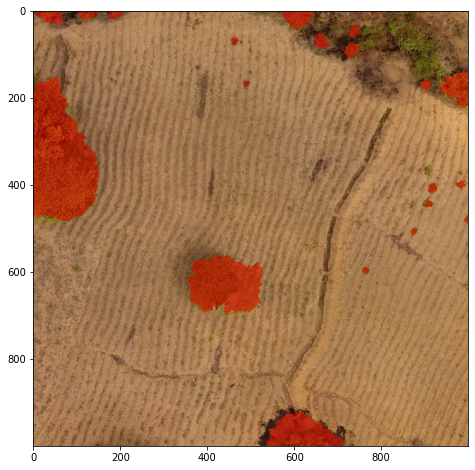

In [54]:
fig1 = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, rgb_tiles_path, annotations, show_image_in_background=True)

/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


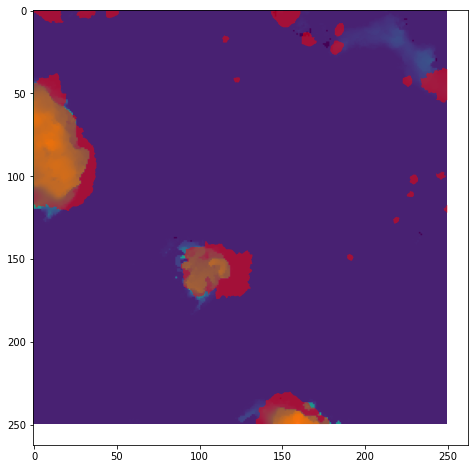

In [35]:
fig2 = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, height_tiles_path, annotations, show_image_in_background=True)

/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


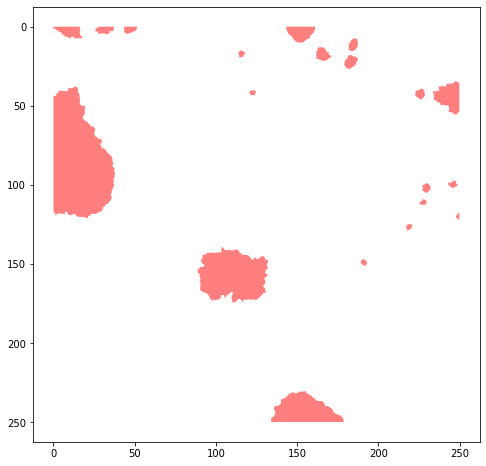

In [61]:
pure_mask = prepare_mask("bumila_year_2019_tile_8000_14000", filename2id, height_tiles_path, annotations, show_image_in_background=False)

In [62]:
import imageio

im = imageio.imread('bumila_year_2019_tile_8000_14000.png')
print(im.shape)

(451, 472, 4)


In [45]:
def create_mask_array(tile_name, tiles_path, filename2id, annotations):
  id = filename2id[tile_name]
  tile_name_elements = tile_name.split("_")
  village = tile_name_elements[0]
  year = tile_name_elements[2]
  img_path = os.path.join(tiles_path, village, year, tile_name+".tiff")
  print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = img_array[0]
  mask_array = np.zeros(img_array.shape)
  for i,annot in enumerate(annotations['annotations']):
    if annot['image_id'] == id:
      # put mask on the image
      segmentation = annotations['annotations'][i]['segmentation']
      for seg in segmentation:
        if img_array.shape[0] == 250:
          x_list = np.array(seg[0::2])/4
          y_list = np.array(seg[1::2])/4
        elif img_array.shape[0] == 1000:
          x_list = np.array(seg[0::2])
          y_list = np.array(seg[1::2])
        else:
          raise ValueError(f"Image dimensions of {img_array.shape} not expected")
        for i in range(len(x_list)):
          mask_array[x_list[i], y_list[i]] = 1
  return mask_array

In [46]:
mask_array = create_mask_array("bumila_year_2019_tile_8000_14000", rgb_tiles_path, filename2id, annotations)

/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/bumila/2019/bumila_year_2019_tile_8000_14000.tiff


In [47]:
mask_array.shape

(1000, 1000)

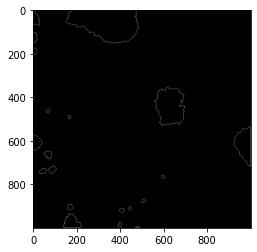

In [49]:
plt.imshow(mask_array, cmap='gray')
plt.show()